In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [1]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-01")

2023/05/31 23:07:19 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-01' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/mikygetyos/Documents/My_Projects/NYC-Taxi-Duration/notebooks-exp-tracking/mlruns/1', creation_time=1685563639467, experiment_id='1', last_update_time=1685563639467, lifecycle_stage='active', name='nyc-taxi-experiment-01', tags={}>

In [8]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda trip_dur_min: trip_dur_min.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [9]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
# Dictionary Vectorization, Training, Prediction and Evaluation

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.499110688198266

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/tmp/ipykernel_46828/3467513732.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_46828/3467513732.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


<Axes: ylabel='Density'>

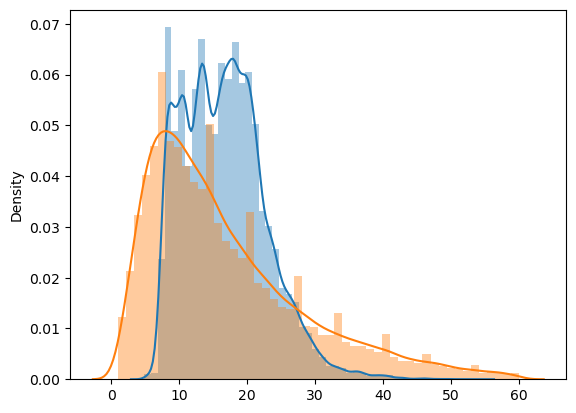

In [15]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

In [16]:
with mlflow.start_run():

    mlflow.set_tag("Model", "Lasso")

    # First Lasso with default parameters
    lr = Lasso()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/lasso_regressor.bin", "wb") as f_out:
        pickle.dump(lr, f_out)

    mlflow.log_artifact(local_path="models/lasso_regressor.bin", artifact_path="Lasso-Model")

In [17]:
with mlflow.start_run():

    mlflow.set_tag("Developer", "Michael Getachew Abebe")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    # Let's try with alpha = 0.001
    lr = Lasso(alpha)

    mlflow.log_param("alpha", alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared = False)

    mlflow.log_metric("Root Mean Squared Error", rmse)

In [18]:
# Let's try with alpha = 0.01
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

10.812725703916977

In [19]:
#Let's try with alpha = 0.1
lr = Lasso(alpha=0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.674811916671658

In [20]:
with mlflow.start_run():

    mlflow.set_tag("Models", "Ridge Regressor")

    # Let's try Ridge
    lr = Ridge()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    with open("models/ridge_regressor.bin", "wb") as f_out:
        pickle.dump(lr, f_out)
    
    mlflow.log_artifact(local_path="models/ridge_regressor.bin", artifact_path="Ridge-Model")


In [21]:
# Hyperparameter Tunning using XGboost

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost-model")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("Root Mean Squared Error", rmse)

    return {'loss':rmse, 'status': STATUS_OK}

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[23:25:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.56676                           
[1]	validation-rmse:6.49709                           
[2]	validation-rmse:6.48563                           
[3]	validation-rmse:6.48925                           
[4]	validation-rmse:6.48645                           
[5]	validation-rmse:6.49841                           
[6]	validation-rmse:6.52134                           
[7]	validation-rmse:6.52755                           
[8]	validation-rmse:6.54027                           
[9]	validation-rmse:6.56013                           
[10]	validation-rmse:6.57990                          
[11]	validation-rmse:6.59095                          
[12]	validation-rmse:6.60352                          
[13]	validation-rmse:6.60744                          
[14]	validation-rmse:6.62111                          
[15]	validation-rmse:6.62774                          
[

SO NOW LET'S TRY TO LOG ALL THE INFORMATION ABOUT THE BEST XGBOOST MODEL USING MLFlows SPECIAL UTILITY CALLED: "autolog"

In [31]:
params = {
    "learning_rate": 0.1475233942720844,
    "max_depth": 6,
    "min_child_weight": 1.1362906087903892,
    "objective": "reg:linear",
    "reg_alpha": 0.05658486179123832,
    "reg_lambda": 0.008071805841860352,
    "seed":42
}

mlflow.xgboost.autolog(log_model_signatures=False)

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)


2023/05/26 16:28:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e2b33bab5eb4d019b0d4141154fbd1a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[16:28:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.58431
[1]	validation-rmse:16.39958
[2]	validation-rmse:14.57823
[3]	validation-rmse:13.06911
[4]	validation-rmse:11.82569
[5]	validation-rmse:10.80780
[6]	validation-rmse:9.97891
[7]	validation-rmse:9.30689
[8]	validation-rmse:8.76598
[9]	validation-rmse:8.33482
[10]	validation-rmse:7.98848
[11]	validation-rmse:7.71246
[12]	validation-rmse:7.49393
[13]	validation-rmse:7.31816
[14]	validation-rmse:7.17774
[15]	validation-rmse:7.06282
[16]	validation-rmse:6.96888
[17]	validation-rmse:6.89457
[18]	validation-rmse:6.83208
[19]	validation-rmse:6.78065
[20]	validation-rmse:6.73977
[21]	validation-rmse:6.70440
[22]	validation-rmse:6.67425
[23]	validation-rmse:6.64596
[24]	validation-rmse:6.62432
[25]	validation-rmse:6.60397
[26]	validation-rmse:6.58641
[27]	validation-rmse:6.57067
[28]	validation-rmse:6.55735
[29]	validation-rmse:6.54510
[30]	validation

In [33]:
with mlflow.start_run():
    
    params = {
    "learning_rate": 0.1475233942720844,
    "max_depth": 6,
    "min_child_weight": 1.1362906087903892,
    "objective": "reg:linear",
    "reg_alpha": 0.05658486179123832,
    "reg_lambda": 0.008071805841860352,
    "seed":42
    }

    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    X_val_matrix = xgb.DMatrix(X_val)
    y_pred = booster.predict(X_val_matrix)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("Root Mean Squared Error", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


[17:18:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.58431
[1]	validation-rmse:16.39958
[2]	validation-rmse:14.57823
[3]	validation-rmse:13.06911
[4]	validation-rmse:11.82569
[5]	validation-rmse:10.80780
[6]	validation-rmse:9.97891
[7]	validation-rmse:9.30689
[8]	validation-rmse:8.76598
[9]	validation-rmse:8.33482
[10]	validation-rmse:7.98848
[11]	validation-rmse:7.71246
[12]	validation-rmse:7.49393
[13]	validation-rmse:7.31816
[14]	validation-rmse:7.17774
[15]	validation-rmse:7.06282
[16]	validation-rmse:6.96888
[17]	validation-rmse:6.89457
[18]	validation-rmse:6.83208
[19]	validation-rmse:6.78065
[20]	validation-rmse:6.73977
[21]	validation-rmse:6.70440
[22]	validation-rmse:6.67425
[23]	validation-rmse:6.64596
[24]	validation-rmse:6.62432
[25]	validation-rmse:6.60397
[26]	validation-rmse:6.58641
[27]	validation-rmse:6.57067
[28]	validation-rmse:6.55735
[29]	validation-rmse:6.54510
[30]	validation

In [44]:
# Disable the auto save since it will the above run included two models where we just had 1, and save the dictionary vectorizer as part of the artifact since it might be useful
# later to do pre-processing on input data while serving the model.

mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    params = {
    "learning_rate": 0.1475233942720844,
    "max_depth": 10,
    "min_child_weight": 1.1362906087903892,
    "objective": "reg:linear",
    "reg_alpha": 0.05658486179123832,
    "reg_lambda": 0.008071805841860352,
    "seed":42
    }

    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    X_val_matrix = xgb.DMatrix(X_val)
    y_pred = booster.predict(X_val_matrix)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("Root Mean Squared Error", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")




[19:00:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.57408
[1]	validation-rmse:16.38332
[2]	validation-rmse:14.55539
[3]	validation-rmse:13.03713
[4]	validation-rmse:11.78580
[5]	validation-rmse:10.75766
[6]	validation-rmse:9.91850
[7]	validation-rmse:9.23948
[8]	validation-rmse:8.69223
[9]	validation-rmse:8.25191
[10]	validation-rmse:7.89980
[11]	validation-rmse:7.61869
[12]	validation-rmse:7.39333
[13]	validation-rmse:7.21213
[14]	validation-rmse:7.06768
[15]	validation-rmse:6.95057
[16]	validation-rmse:6.85483
[17]	validation-rmse:6.77769
[18]	validation-rmse:6.71307
[19]	validation-rmse:6.65827
[20]	validation-rmse:6.61362
[21]	validation-rmse:6.57486
[22]	validation-rmse:6.54542
[23]	validation-rmse:6.51678
[24]	validation-rmse:6.49280
[25]	validation-rmse:6.47125
[26]	validation-rmse:6.45397
[27]	validation-rmse:6.43890
[28]	validation-rmse:6.42555
[29]	validation-rmse:6.41334
[30]	validation

NOW THAT OUR MODEL IS READY AND SAVED WE CAN IMPORT BOTH FLAVORS OF THE MODEL
1) A python function
2) An XGboost Model

In [37]:
# 1) THE MODEL AS A PYTHON FUNCTION
logged_model = 'runs:/e4f61f89f2c74837ab1b69bcea486e5c/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/05/26 17:36:47 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[17:36:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: e4f61f89f2c74837ab1b69bcea486e5c

In [39]:
#2) THE MODEL AS AN XGBOOST MODEL
xgb_model = mlflow.xgboost.load_model(logged_model)

[17:38:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
xgb_model

TRAIN ANOTHER VARIATION MODEL(GRADIENTBooSTINGREFRESSOR) FOR COMPARING PERFORMANCE WITH THE XGBooST MODEL